In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import signal
%matplotlib inline

def intRange(iMin,iMax,step=1):
    return np.arange(iMin,iMax+1, step, dtype=int)

def INIT_UVP(UI,VI,PI,imax,jmax):
    U = UI*np.ones((imax+2,jmax+2))
    V = VI*np.ones((imax+2,jmax+2))
    P = PI*np.ones((imax+2,jmax+2))
    F =    np.zeros((imax+2,jmax+2))
    G =    np.zeros((imax+2,jmax+2))
    return U, V, P, F, G

def COMP_DELT(delt,imax,jmax,delx,dely,U,V,Re,tau):
    zeroReplace = 0.00000001
    if tau<0:
        return delt
    else:
        delx2 = delx**2
        dely2 = dely**2
        tmpA  = 0.5*Re*(delx2*dely2)/(delx2+dely2)
        tmpB  = delx/(np.amax(np.abs(U))+zeroReplace)
        tmpC  = dely/(np.amax(np.abs(V))+zeroReplace)
        return tau*min(tmpA,tmpB,tmpC)

def SETBCOND(U,V,imax,jmax,wW,wE,wN,wS):
    WN = np.zeros((imax+2,jmax+2))
    WS = np.zeros((imax+2,jmax+2))
    WW = np.zeros((imax+2,jmax+2))
    WE = np.zeros((imax+2,jmax+2))
    w  = np.zeros((imax+2,jmax+2))
    
    for i in intRange(1,imax):
        w[i,   0] = wS
        w[i,jmax] = wN
    for j in intRange(1,jmax):
        w[0   ,j] = wW
        w[imax,j] = wE
    return w
    
def SETGEOMETRY(imax,jmax,w,obstacleCells):
    # obstacle->0  fluid->1
    OBS  = np.ones((imax+2,jmax+2))
    FLAG = np.ones((imax+2,jmax+2))
    epsN = np.ones((imax+2,jmax+2))
    epsS = np.ones((imax+2,jmax+2))
    epsW = np.ones((imax+2,jmax+2))
    epsE = np.ones((imax+2,jmax+2))
    
    for i, j in obstacleCells:
        OBS[i,j] = 0.0
    
    for i in intRange(1,imax):
        epsS[i,1]    = 0.0
        epsN[i,jmax] = 0.0
        
    for j in intRange(1,jmax):
        epsW[1   ,j] = 0.0
        epsE[imax,j] = 0.0
        
    return FLAG, epsN, epsS, epsW, epsE

def SETSPECBCOND(U,V,imax,jmax,w):
    return w

def COMP_FG(U,V,F,G,imax,jmax,delt,delx,dely,GX,GY,gamma,Re):
    delx2 = delx*delx
    dely2 = dely*dely

    #(3.36) and (3.37)
    for i in intRange(1,imax-1):
        for j in intRange(1,jmax):
            UXX = (U[i+1,j]-2*U[i,j]+U[i-1,j])/delx2
            UYY = (U[i,j+1]-2*U[i,j]+U[i,j-1])/dely2

            U00pp0 = U[i  ,j]+U[i+1,j]
            Um0p00 = U[i-1,j]+U[i  ,j]
            U00mp0 = U[i  ,j]-U[i+1,j]
            Um0m00 = U[i-1,j]-U[i  ,j]
            U2X    = (U00pp0**2-Um0p00**2)/(4*delx)+gamma/(4*delx)*(abs(U00pp0)*U00mp0-abs(Um0p00)*Um0m00)

            U00p0p = U[i,  j  ]+U[i  ,j+1]
            U0mp00 = U[i,  j-1]+U[i  ,j  ]
            U00m0p = U[i,  j  ]-U[i  ,j+1]
            U0mm00 = U[i,  j-1]-U[i  ,j  ]
            V00pp0 = V[i,  j  ]+V[i+1,j  ]
            V0mppm = V[i  ,j-1]+V[i+1,j-1]
            UVY    = (V00pp0*U00p0p-V0mppm*U0mp00)/(4*delx)+gamma/(4*delx)*(abs(V00pp0)*U00m0p-abs(V0mppm)*U0mm00)
                   
            F[i,j] = U[i,j] + delt*(1/Re*(UXX+UYY)-U2X-UVY+GX)
    
    for i in intRange(1,imax):
        for j in intRange(1,jmax-1):   
            VXX = (V[i+1,j]-2*V[i,j]+V[i-1,j])/delx2
            VYY = (V[i,j+1]-2*V[i,j]+V[i,j-1])/dely2
            
            V00p0p = V[i  ,j  ]+V[i  ,j+1]
            V0mp00 = V[i  ,j-1]+V[i  ,j  ]
            V00m0p = V[i  ,j  ]-V[i  ,j+1]
            V0mm00 = V[i  ,j-1]-V[i  ,j  ]            
            V2Y = (V00p0p**2-V0mp00**2)/(4*dely)+gamma/(4*dely)*(abs(V00p0p)*V00m0p-abs(V0mp00)*V0mm00)

            Vm0p00 = V[i-1,j  ]+V[i  ,j  ]
            V00mp0 = V[i  ,j  ]-V[i+1,j  ]
            Vm0m00 = V[i-1,j  ]-V[i  ,j  ]
            V00pp0 = V[i  ,j  ]+V[i+1,j  ]
            U00p0p = U[i  ,j  ]+U[i  ,j+1]
            Um0pmp = U[i-1,j  ]+U[i-1,j+1]
            UVX    = (U00p0p*V00pp0-Um0pmp*Vm0p00)/(4*dely)+gamma/(4*dely)*(abs(U00p0p)*V00mp0-abs(Um0pmp)*Vm0m00)
          
            G[i,j] = V[i,j] + delt*(1/Re*(VXX+VYY)-UVX-V2Y+GY)
    
    # (3.42)
    for i in intRange(1,imax):
        G[i,   0] = V[i,   0]
        G[i,jmax] = V[i,jmax]
    for j in intRange(1,jmax):
        F[0   ,j] = U[0   ,j]
        F[imax,j] = U[imax,j]
    return F, G

def COMP_RHS(F,G,imax,jmax,delt,delx,dely):
    # (3.38)
    RHS = np.zeros((imax+2,jmax+2))
    for i in intRange(1,imax):
        for j in intRange(1,jmax):
            tmp1 = (F[i,j]-F[i-1,j])/delx
            tmp2 = (G[i,j]-G[i,j-1])/dely
            RHS[i,j] = 1/delt*(tmp1 + tmp2)
    #RHS = 1/delt*(np.add(F,-np.roll(F, -1, axis=0))/delx + np.add(G,-np.roll(G, -1, axis=1))/delx)
    return RHS

def POISSON(P,RHS,imax,jmax,delx,dely,eps,itermax,omg,res,epsN,epsS,epsW,epsE):
    delx2   = delx**2
    dely2   = dely**2
    it      = 0
    PN      = np.zeros((imax+2,jmax+2))
    rit     = np.zeros((imax+2,jmax+2))
    ritNorm = 2*eps
    while it<itermax and ritNorm>eps:
        # Interior (3.44)
        for i in intRange(1,imax):
            for j in intRange(1,jmax):
                #quotient = (epsE[i,j]         +epsW[i,j]          )/delx2 + (epsN[i,j]         +epsS[i,j]         )/dely2
                #factor   = (epsE[i,j]*P[i+1,j]+epsW[i,j]*PN[i-1,j])/delx2 + (epsN[i,j]*P[i,j+1]+epsS[i,j]*PN[i,j-1])/dely2 - RHS[i,j]
                
                quotient = 2.0/delx2 + 2.0/dely2
                factor   = (P[i+1,j]+PN[i-1,j])/delx2 + (P[i,j+1]+PN[i,j-1])/dely2 - RHS[i,j]
                PN[i,j]  = (1-omg)*P[i,j] + omg/quotient*factor

        # boundary (3.48)
        for i in intRange(1,imax):
            PN[i,0]      = P[i,1]
            PN[i,jmax+1] = P[i,jmax]          
        for j in intRange(1,jmax):      
            PN[0,j]      = P[1,j]
            PN[imax+1,j] = P[imax,j]

        # (3.48)
        ritNorm = 0
        for i in intRange(1,imax):
            for j in intRange(1,jmax):
                PNij     = PN[i,j]
                tmp1     = (epsE[i,j]*(PN[i+1,j]-PNij)-epsW[i,j]*(PNij-PN[i-1,j]))/delx2
                tmp2     = (epsN[i,j]*(PN[i,j+1]-PNij)-epsS[i,j]*(PNij-PN[i,j-1]))/dely2
                rit      = tmp1 + tmp2 - RHS[i,j]
                ritNorm  = ritNorm + rit**2
        ritNorm = np.sqrt(ritNorm/(imax*jmax))
        
        #P = np.copy(PN)
        #P[:] = PN
        #P = PN
        for i in intRange(0,imax+1):
            for j in intRange(0,jmax+1):
                P[i,j]=PN[i,j]
        it = it + 1
    print('    it: ',it,ritNorm, P.shape,PN.shape)
    return PN

def ADAP_UV(U,V,F,G,P,imax,jmax,delt,delx,dely):
    #U = np.add(F,-delt/delx*np.add(np.roll(P, +1, axis=0)),-P)
    #V = np.add(G,-delt/delx*np.add(np.roll(P, +1, axis=1)),-P)

    # (3.34)
    for i in intRange(1,imax-1):
        for j in intRange(1,jmax):
            U[i,j] = F[i,j] - delt/delx*(P[i+1,j]-P[i,j])
    # (3.35)
    for i in intRange(1,imax):
        for j in intRange(1,jmax-1):
            V[i,j] = G[i,j] - delt/dely*(P[i,j+1]-P[i,j])

    # (3.23)
    for j in intRange(1,jmax):
        V[0     ,j]=-V[   1,j]
        V[imax+1,j]=-V[imax,j]
    for i in intRange(1,imax):
        U[i,   0]=-U[i   ,1]
        U[i,jmax]=-U[i   ,jmax]
        

    ubar = 2.0
    for i in intRange(1,imax):
        U[i,jmax+1] = 2.0*ubar-U[i,jmax]
    
    
    return U, V

def run(xlength,ylength,imax,jmax,t,t_end,delt,tau,itermax,res,eps,omg,gamma,Re,GX,GY,UI,VI,PI,wW,wE,wN,wS):
    delx  = xlength/imax
    dely  = ylength/jmax
    
    Uhist = []
    Vhist = []
    Phist = []
    U,V,P,F,G = INIT_UVP(UI,VI,PI,imax,jmax)
    w         = SETBCOND(U,V,imax,jmax,wW,wE,wN,wS)
    FLAG, epsN, epsS, epsW, epsE  = SETGEOMETRY(imax,jmax,w,obstacleCells)
    w         = SETSPECBCOND(U,V,imax,jmax,w)
    pos       = generateParticle()

    step = 1
    while t<t_end and step <5:
        deltc = COMP_DELT(delt,imax,jmax,delx,dely,U,V,Re,tau)
        print('tIter:',step,'time:',t,'deltc:',deltc)
        F,G   = COMP_FG(U,V,F,G,imax,jmax,deltc,delx,dely,GX,GY,gamma,Re)
        RHS   = COMP_RHS(F,G,imax,jmax,deltc,delx,dely)
        P     = POISSON(P,RHS,imax,jmax,delx,dely,eps,itermax,omg,res,epsN, epsS, epsW, epsE)
        U,V   = ADAP_UV(U,V,F,G,P,imax,jmax,deltc,delx,dely)
        
        Uhist.append(U)
        Vhist.append(V)
        Phist.append(P)
        
        pos   = updatePosition(pos,deltc,delx,dely,U,V)
        t     = t + deltc
        step  = step+1
    return Uhist,Vhist,Phist,pos

def getUatLocation(U,x,y,delx,dely):
    i, j = [int(x/delx)+1, int((y+0.5*dely)/dely)+1]
    x1,x2,y1,y2 = [(i-1)*delx, i*delx, ((j-1)-0.5)*dely, (j-0.5)*dely]
    u1,u2,u3,u4 = [U[i-1,j-1],U[i,j-1],U[i-1,j],U[i,j]]
    tmp1 = (x2-x)*(y2-y)*u1
    tmp2 = (x-x1)*(y2-y)*u2
    tmp3 = (x2-x)*(y-y1)*u3
    tmp4 = (x-x1)*(y-y1)*u4
    u    = (tmp1+tmp2+tmp3+tmp4)/(delx*dely)
    return u

def getVatLocation(V,x,y,delx,dely):
    i, j = [int((x+0.5*delx)/delx)+1, int(y/dely)+1]
    x1,x2,y1,y2 = [((i-1)-0.5)*delx, (i-0.5)*delx, (j-1)*dely, j*dely]
    v1,v2,v3,v4 = [V[i-1,j-1],V[i,j-1],V[i-1,j],V[i,j]]
    tmp1 = (x2-x)*(y2-y)*v1
    tmp2 = (x-x1)*(y2-y)*v2
    tmp3 = (x2-x)*(y-y1)*v3
    tmp4 = (x-x1)*(y-y1)*v4
    v    = (tmp1+tmp2+tmp3+tmp4)/(delx*dely)
    return v

def generateParticle():
    pos = [[0.25,0.25]]
    return pos

def updatePosition(pos,delt,delx,dely,U,V):
    x,y = pos[-1]
    u = getUatLocation(U,x,y,delx,dely)
    v = getVatLocation(V,x,y,delx,dely)
    #print('    u,v:',u,v)
    xn = x + delt*u
    yn = y + delt*v
    pos.append([xn,yn])
    return pos

In [7]:
inputParameters={"xlength":1.0,"ylength":1.0,"imax":32,"jmax":32,
               "t":0,"t_end":2,"delt":0.02,"tau":0.5,
               "itermax":1000,"res":10,"eps":0.001,"omg":1.7,"gamma":0.9,
               "Re":1000,"GX":0.00,"GY":9.81,"UI":0.0,"VI":0.0,"PI":0.0,
               "wW":2,"wE":2,"wN":2,"wS":2}

for key in inputParameters.keys():
    if isinstance(inputParameters[key], int):
        exec("%s = %d" % (key,inputParameters[key]))
    if isinstance(inputParameters[key], float):
        exec("%s = %f" % (key,inputParameters[key]))
        
#obstacleCells = np.array([[0,0]])
#obstacleCells = np.concatenate((obstacleCells,np.array([[0   ,   j] for j in np.arange(jmax+1)])))   # N
#obstacleCells = np.concatenate((obstacleCells,np.array([[imax,   j] for j in np.arange(jmax+1)])))   # S
#obstacleCells = np.concatenate((obstacleCells,np.array([[i   ,   0] for i in np.arange(imax+1)])))   # W
#obstacleCells = np.concatenate((obstacleCells,np.array([[i   ,jmax] for i in np.arange(imax+1)])))   # E
#obstacleCells = np.delete(obstacleCells,1,0)
obstacleCells = []

Uhist,Vhist,Phist,pos = run(xlength,ylength,imax,jmax,t,t_end,delt,tau,itermax,res,eps,omg,gamma,Re,GX,GY,UI,VI,PI,wW,wE,wN,wS)

tIter: 1 time: 0 deltc: 0.1220703125
    it:  728 0.0009928663719363097 (34, 34) (34, 34)
tIter: 2 time: 0.1220703125 deltc: 0.003906245593200176
    it:  602 0.0009987641020917104 (34, 34) (34, 34)
tIter: 3 time: 0.12597655809320019 deltc: 0.003891659709802706
    it:  597 0.0009897206798975995 (34, 34) (34, 34)
tIter: 4 time: 0.1298682178030029 deltc: 0.003899976560281064
    it:  597 0.0009902009706005395 (34, 34) (34, 34)


32 32
32 32
(34, 34)


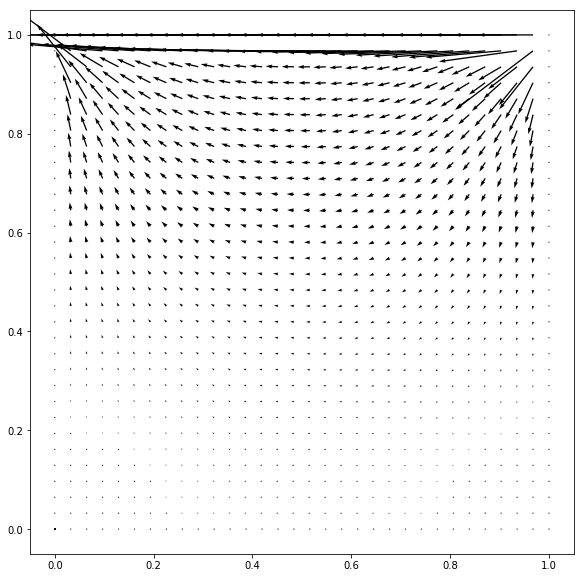

In [8]:
print(imax,jmax)
print(len(np.linspace(0,xlength,imax)),len(np.linspace(0,ylength,jmax)))

delx  = xlength/imax
dely  = ylength/jmax

n=-1
for i in intRange(1,imax):
    Uhist[n][i,jmax+1] = 0
    
x1 = np.zeros((imax+2,jmax+2))
y1 = np.zeros((imax+2,jmax+2))
u1 = np.zeros((imax+2,jmax+2))
v1 = np.zeros((imax+2,jmax+2))

print(u1.shape)

for i, x in enumerate(np.linspace(0,xlength,imax)):
    for j, y in enumerate(np.linspace(0,ylength,jmax)):
        x1[i,j] = x
        y1[i,j] = y
        
        u1[i,j] = getUatLocation(Uhist[n],x,y,delx,dely)
        v1[i,j] = getVatLocation(Vhist[n],x,y,delx,dely)
    
fig = plt.figure(figsize = (10,10))
ax  = plt.subplot(1,1,1)
ax.quiver(x1,y1,u1,v1)
ax.set_aspect(1.)
plt.show()

In [152]:
Uhist[n]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 6.24833722e-06, -6.24833722e-06, -6.80620860e-06, ...,
        -4.01731353e-03, -7.73370344e-03,  4.00773370e+00],
       [ 1.33445312e-05, -1.33445312e-05, -1.44594423e-05, ...,
        -2.56834753e-03, -7.69594429e-03,  4.00769594e+00],
       ...,
       [ 6.85134021e-06, -6.85134021e-06, -7.43607150e-06, ...,
        -4.01524930e-03, -7.73717246e-03,  4.00773717e+00],
       [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -0.00000000e+00,  4.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

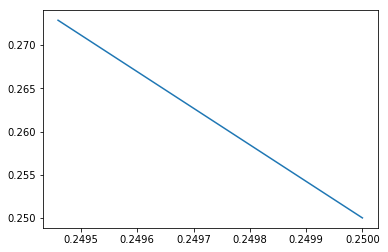

In [11]:
x=np.array(pos).transpose()[0]
y=np.array(pos).transpose()[1]
plt.plot(x,y)

[[0.  0.5 1. ]
 [0.  0.5 1. ]
 [0.  0.5 1. ]]

[[0.   0.   0.  ]
 [0.25 0.25 0.25]
 [0.5  0.5  0.5 ]]

[[0.  0.  0.1]
 [0.  0.  0.1]
 [0.  0.  0. ]]


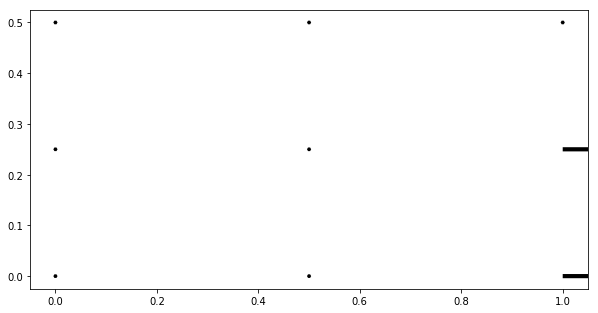

In [114]:
X    = np.linspace(0,xlength,3)
Y    = np.linspace(0,ylength,3)
U    = np.array([[0.0   ,0.0   ,0.1],
                 [0.0   ,0.0   ,0.1],
                 [0.0   ,0.0   ,0.0]])
V    = np.array([[0.0   ,0.0   ,0.0],
                 [0.0   ,0.0   ,0.0],
                 [0.0   ,0.0   ,0.0]])


X, Y = np.meshgrid(X, Y)
print(X)
print()
print(Y)
print()
print(U)
fig = plt.figure(figsize = (10,10))
ax  = plt.subplot(1,1,1)
ax.quiver(X,Y,U,V)
ax.set_aspect(1.)
plt.show()

In [105]:
np.zeros((1,2))

array([[0., 0.]])

In [15]:
delx = 1.0/128
dely = 1.0/128
omg = 1.7
P   = 0.0
for it in range(10):
    P = (1-omg)*P + omg/(2.0/delx**2+dely**2)
    print(it,' - ',P)

0  -  5.1879882715866184e-05
1  -  1.5563964814759857e-05
2  -  4.0985107345534285e-05
3  -  2.3190307573992188e-05
4  -  3.564666741407166e-05
5  -  2.6927215526016025e-05
6  -  3.303083184765497e-05
7  -  2.8758300422507707e-05
8  -  3.1749072420110785e-05
9  -  2.9655532021788637e-05
